In [47]:
# Importing Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil

In [48]:
# Transform Dataset (jpg to data)
# Define paths to your dataset directories
source_data_dir = "/content/source"
target_train_dir = "/content/train"
target_test_dir = "/content/test"

In [49]:
# Create target directories if they don't exist
os.makedirs(target_train_dir, exist_ok=True)
os.makedirs(target_test_dir, exist_ok=True)

In [50]:
# Function to move files from source directory to target directory
def move_files(source_dir, target_dir, split_ratio=0.8):
    files = os.listdir(source_dir)
    train_size = int(len(files) * split_ratio)

    # Create subdirectories for train and test data
    train_subdir = os.path.join(target_dir, 'train')
    test_subdir = os.path.join(target_dir, 'test')
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)

    for i, file in enumerate(files):
        src = os.path.join(source_dir, file)
        if i < train_size:
            dst = os.path.join(train_subdir, file)
        else:
            dst = os.path.join(test_subdir, file)
        shutil.copy(src, dst)

In [51]:
# Split data into train and test directories
move_files(source_data_dir, target_train_dir)
move_files(source_data_dir, target_test_dir, split_ratio=0.2)

In [52]:
# Load Dataset
train_dir = "/content/train"
test_dir = "/content/test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 25 images belonging to 2 classes.
Found 38 images belonging to 3 classes.


**EDA**

In [53]:
# Get the count of files in each directory
train_count = sum(len(files) for _, _, files in os.walk(train_dir))
test_count = sum(len(files) for _, _, files in os.walk(test_dir))

In [54]:
# Display the count of images in each directory
print("Train Images:", train_count)
print("Test Images:", test_count)

Train Images: 42
Test Images: 38


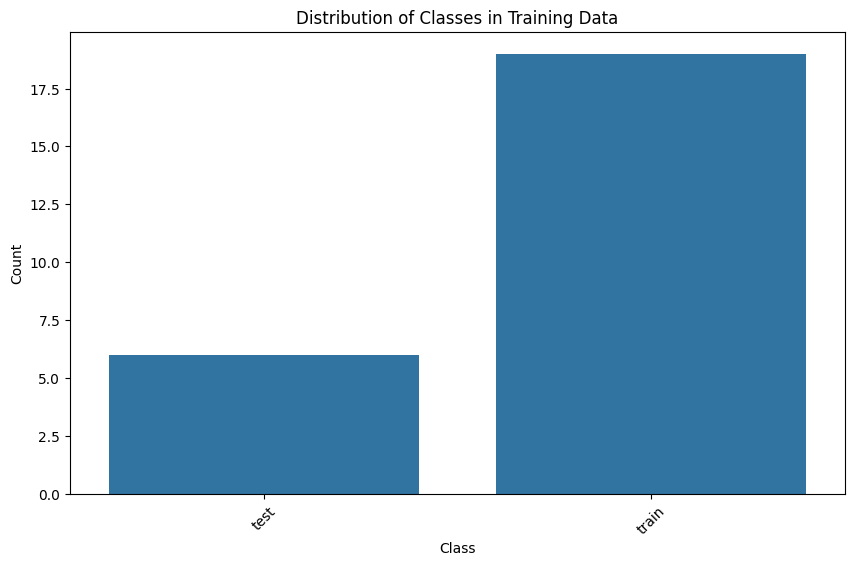

In [55]:
# Plot a bar chart to visualize the distribution of classes in the training data
train_classes = [dir for dir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, dir))]
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes]

plt.figure(figsize=(10, 6))
sns.barplot(x=train_classes, y=class_counts)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

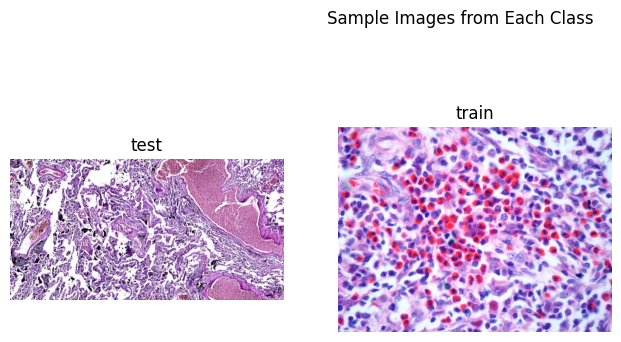

In [56]:
# Display sample images from each class
plt.figure(figsize=(12, 8))
for i, cls in enumerate(train_classes):
    sample_img = os.listdir(os.path.join(train_dir, cls))[0]
    img_path = os.path.join(train_dir, cls, sample_img)
    img = plt.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

In [57]:
# Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.layers[0].trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
# Train your model using the fit() function
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=test_generator,
    validation_steps=50
)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 1.1702 - accuracy: 0.4000

1/1 [==============================] - 13s 13s/step - loss: 1.1702 - accuracy: 0.4000 - val_loss: -1.3550 - val_accuracy: 0.5263
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 1.5065 - accuracy: 0.6000
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 0.8191 - accuracy: 0.6000
Epoch 4/15
1/1 [==============================] - 4s 4s/step - loss: 0.6183 - accuracy: 0.7000
Epoch 5/15
1/1 [==============================] - 5s 5s/step - loss: 0.7526 - accuracy: 0.5500
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 0.6511 - accuracy: 0.8000
Epoch 7/15
1/1 [==============================] - 1s 1s/step - loss: 0.4226 - accuracy: 0.8000
Epoch 8/15
1/1 [==============================] - 4s 4s/step - loss: 0.6120 - accuracy: 0.7500
Epoch 9/15
1/1 [==============================] - 5s 5s/step - loss: 0.5648 - accuracy: 0.8000
Epoch 10/15
1/1 [==============================] - 4s 4s/step - loss: 0.3911 - accuracy: 0.8500
Epoch 11/15
1/1

In [59]:
# Make predictions using the trained model
predictions = model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions = np.round(predictions)

2/2 [==============================] - 9s 4s/step


In [61]:
# Evaluate the model's performance
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 9s 5s/step - loss: -0.4804 - accuracy: 0.3947
Test Loss: -0.48040083050727844
Test Accuracy: 0.3947368562221527


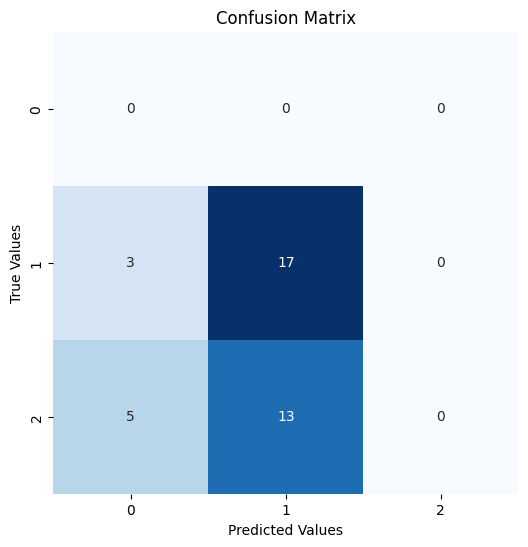

In [74]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.classes, binary_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()

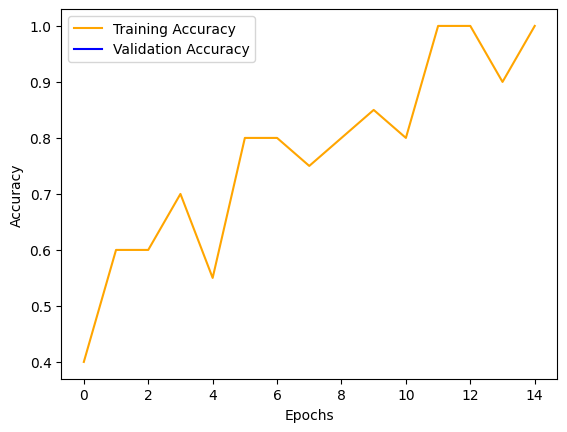

In [83]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

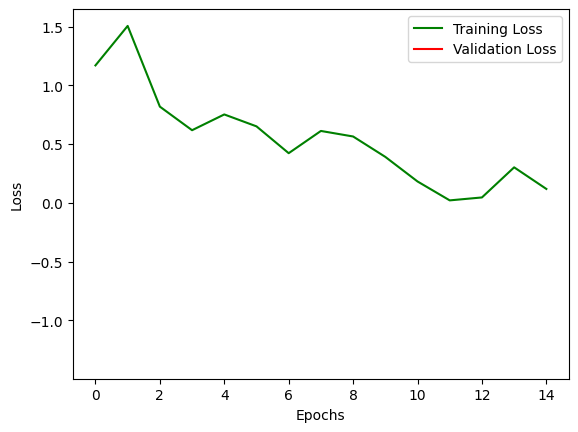

In [84]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [79]:
# Prediction and Evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


2/2 [==============================] - 11s 5s/step - loss: -0.4804 - accuracy: 0.3947
Test Loss: -0.4804008901119232
Test Accuracy: 0.3947368562221527


2/2 [==============================] - 8s 4s/step


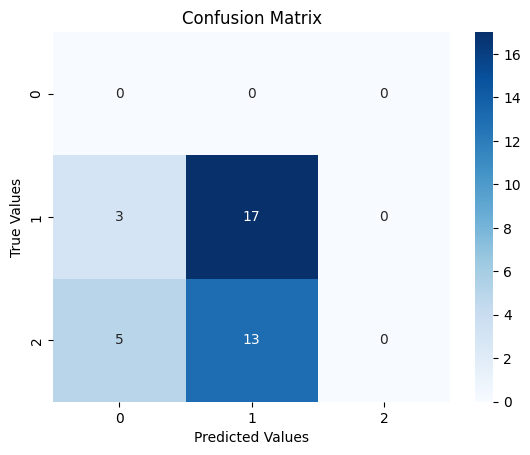

In [80]:
# Confusion matrix
predictions = model.predict(test_generator)
y_pred = np.round(predictions)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()

In [81]:
# Flatten y_true and y_pred arrays if they are not already flattened
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Get the unique classes from y_true and y_pred
unique_classes = np.unique(np.concatenate((y_true_flat, y_pred_flat)))

# Check the number of unique classes
num_classes = len(unique_classes)

# Generate classification report with proper labels
print(classification_report(y_true_flat, y_pred_flat, labels=unique_classes, target_names=['Healthy Person', 'Affected by Cancer']))


                    precision    recall  f1-score   support

    Healthy Person       0.00      0.00      0.00         0
Affected by Cancer       0.57      0.85      0.68        20

          accuracy                           0.45        38
         macro avg       0.19      0.28      0.23        38
      weighted avg       0.30      0.45      0.36        38



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 3, does not match size of target_names, 2
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio